In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utils as mutil
import sklearn
import sklearn.tree
import sklearn.ensemble
import sklearn.model_selection

In [2]:
titanic_train = pd.read_csv("titanic/train.csv")
titanic_test = pd.read_csv("titanic/test.csv")
titanic_submission_ex = pd.read_csv("titanic/gender_submission.csv")

In [3]:
titanic_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [4]:
# We're defining a function missing data to check if the values missing in the differents data_set and then 
#to decide how to handle missing values

def missingdata(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    ms=pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    ms= ms[ms["Percent"] > 0]
    f,ax =plt.subplots(figsize=(8,6))
    plt.xticks(rotation='90')
    fig=sns.barplot(ms.index, ms["Percent"],color="green",alpha=0.8)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)
    return ms

C:\Users\Yon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Total,Percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467


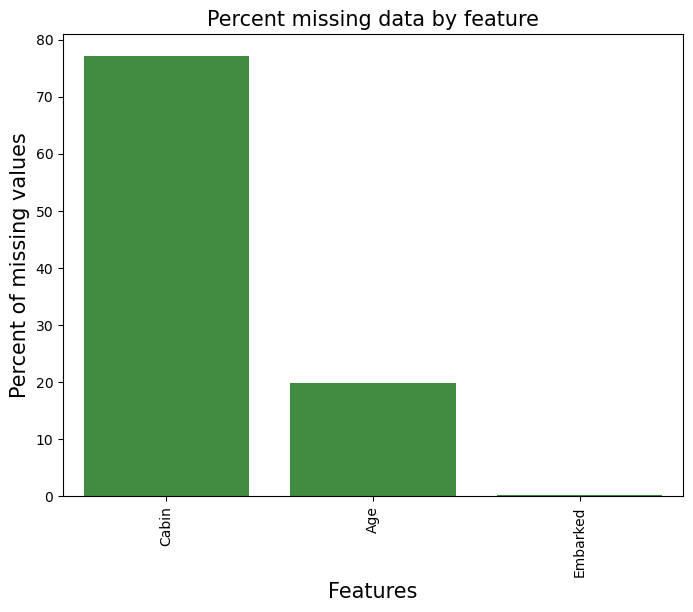

In [5]:
missingdata(titanic_train)


C:\Users\Yon\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,Total,Percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234


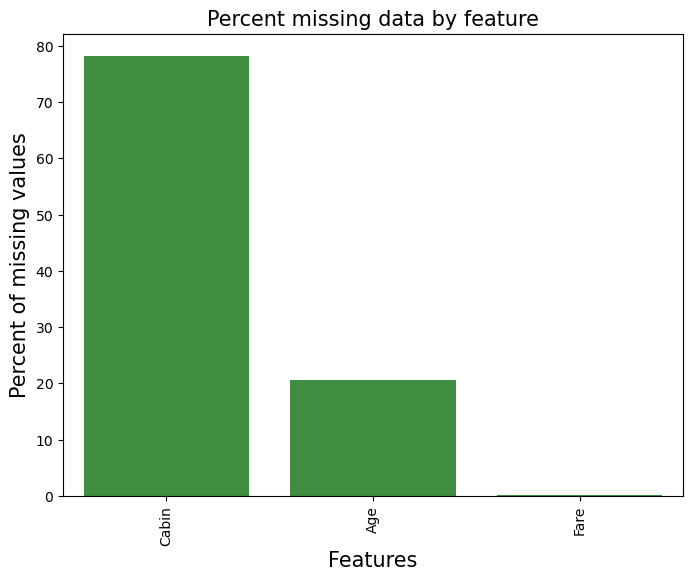

In [6]:
missingdata(titanic_test)

In [7]:
titanic_train['Embarked'].fillna(titanic_train['Embarked'].mode()[0], inplace = True) # We remark that there were values for
#the Embarked futures in our titanic_test missing in the titanic_train. So we decide to fill the titanic_train as many values
#were missed.
titanic_test['Fare'].fillna(titanic_test['Fare'].median(), inplace = True)


#Cabin Featueres has more than 75% of missing data in both Test and train data so we are remove the Cabin
drop_column = ['Cabin']
titanic_train.drop(drop_column, axis=1, inplace = True)
titanic_test.drop(drop_column,axis=1,inplace=True) 



In [8]:
#Both the test and train Age features contains more the 15% of missing Data so we are fill with the median¶
titanic_train['Age'].fillna(titanic_train['Age'].mean(), inplace = True)
titanic_test['Age'].fillna(titanic_test['Age'].mean(), inplace = True)

In [9]:
# We are now checking if all null/nan values are well replaced.
print('check the nan value in train data')
print(titanic_train.isnull().sum())
print('___'*30)
print('check the nan value in test data')
print(titanic_test.isnull().sum())

check the nan value in train data
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64
__________________________________________________________________________________________
check the nan value in test data
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64


In [10]:
## combine test and train as single to apply some function
all_data=[titanic_train,titanic_test]

In [11]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [12]:
import re
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [13]:
titanic_train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,S,2,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C,2,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,S,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,S,2,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,S,1,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,S,1,Rare
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,S,1,Miss
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,S,4,Miss
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,C,1,Mr


In [14]:
## create a binary for age features
for dataset in all_data:
    dataset['Age_bin'] = pd.cut(dataset['Age'], bins=[0,12,20,50,95,], labels=['Children','Teenage','Adult','Elder'])

In [15]:
## create a binary for fare features
for dataset in all_data:
    dataset['Fare_bin'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','Median_fare','Average_fare','High_fare'])

In [16]:
### for keeping a reference of our numerical analysis, we save a copy of the data
trainset=titanic_train
testset=titanic_test

In [17]:
all_dat=[trainset,testset]

In [18]:
trainset.columns
testset.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Embarked', 'FamilySize', 'Title', 'Age_bin',
       'Fare_bin'],
      dtype='object')

In [19]:
for dataset in all_dat:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [20]:
# We are dropping PassengerId column because is just a coutner id
drop_column = ['PassengerId']
trainset.drop(drop_column, axis=1, inplace = True)

In [21]:
trainset = pd.get_dummies(trainset, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [22]:
testset = pd.get_dummies(testset, columns = ["Sex","Title","Age_bin","Embarked","Fare_bin"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

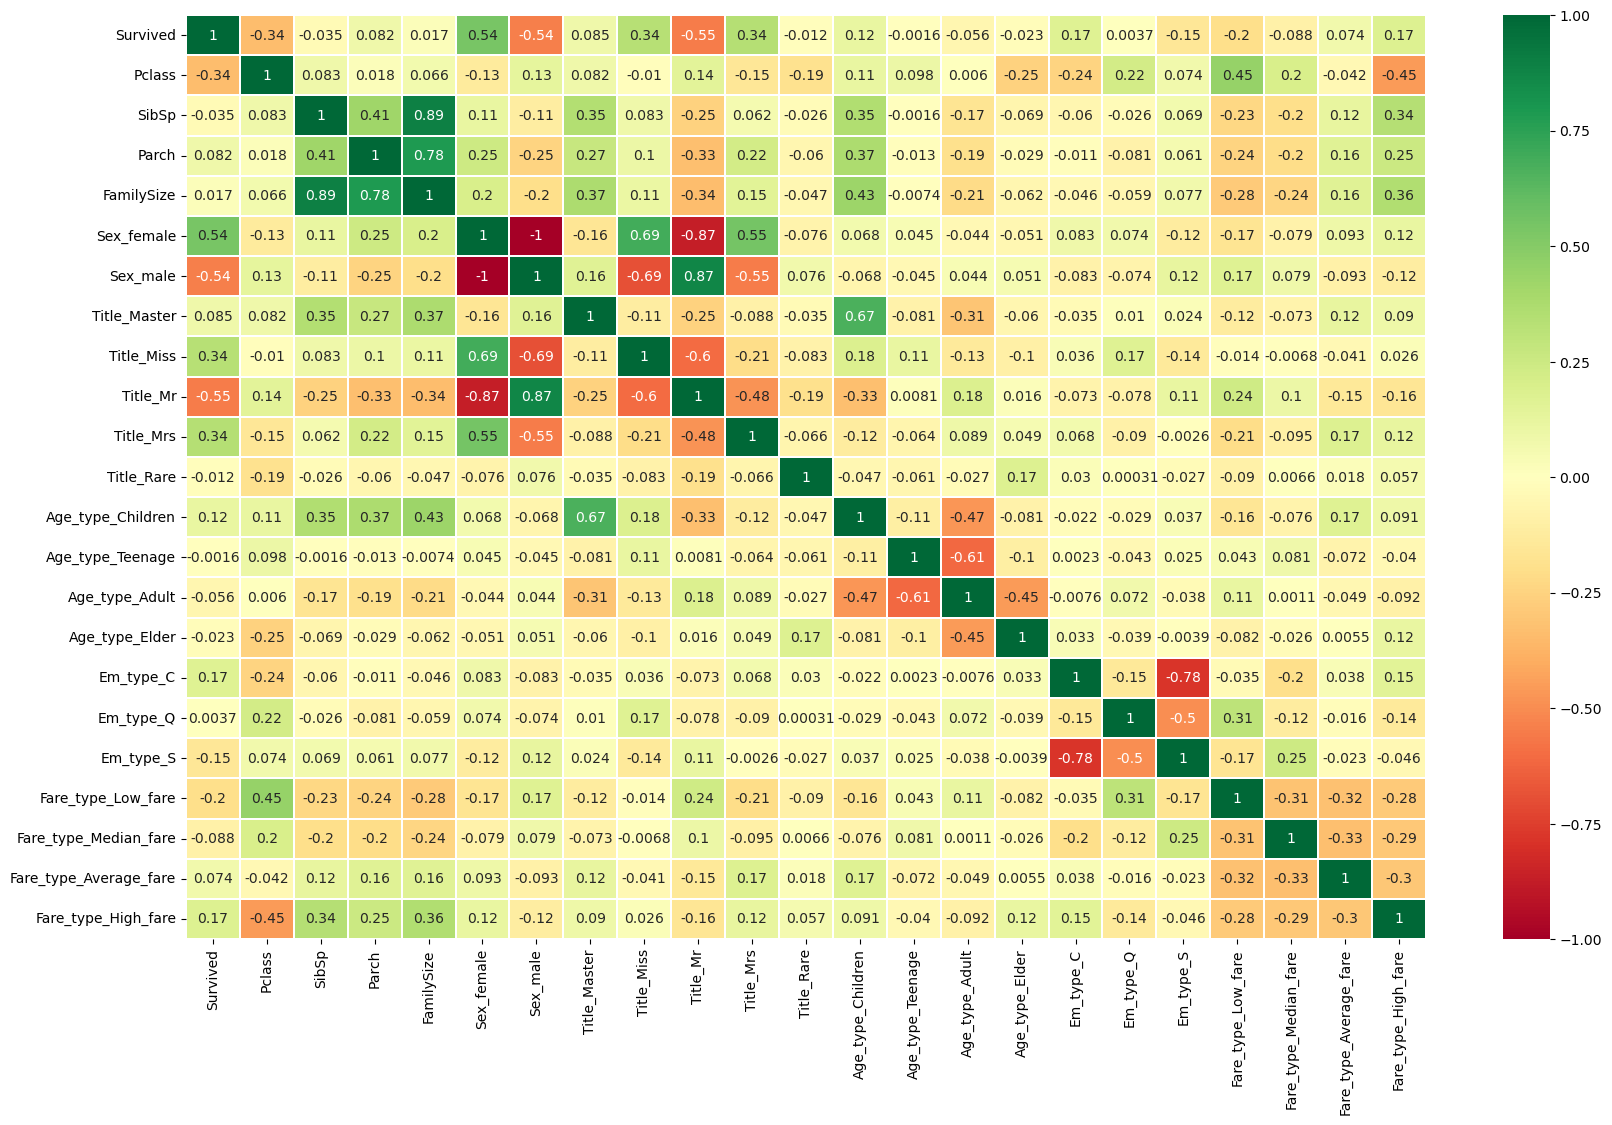

In [23]:
sns.heatmap(trainset.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split #for split the data
from sklearn.metrics import accuracy_score  #for accuracy_score
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
from sklearn.metrics import confusion_matrix #for confusion matrix
all_features = trainset.drop("Survived",axis=1)
Targeted_feature = trainset["Survived"]
X_train,X_test,y_train,y_test = train_test_split(all_features,Targeted_feature,test_size=0.3,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((623, 22), (268, 22), (623,), (268,))

In [25]:
model = KNeighborsClassifier(n_neighbors = 4)
model = model.fit(X_train,y_train)
prediction_knn_train=model.predict(X_train)
prediction_knn_test=model.predict(X_test)
print('--------------The Accuracy of the model----------------------------')
print('The accuracy of the K Nearst Neighbors Classifier on train set is',round(accuracy_score(prediction_knn_train,y_train)*100,2))
print('The accuracy of the K Nearst Neighbors Classifier on test set is',round(accuracy_score(prediction_knn_test,y_test)*100,2))
kfold = KFold(n_splits=10, random_state=22, shuffle=True) # k=10, split the data into 10 equal parts
result_knn=cross_val_score(model,all_features,Targeted_feature,cv=10,scoring='accuracy')
print('The cross validated score for K Nearest Neighbors Classifier is:',round(result_knn.mean()*100,2))
y_pred = cross_val_predict(model,all_features,Targeted_feature,cv=10)

C:\Users\Yon\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Yon\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

--------------The Accuracy of the model----------------------------
The accuracy of the K Nearst Neighbors Classifier on train set is 86.36
The accuracy of the K Nearst Neighbors Classifier on test set is 80.6
The cross validated score for K Nearest Neighbors Classifier is: 81.26


C:\Users\Yon\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
C:\Users\Yon\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` t

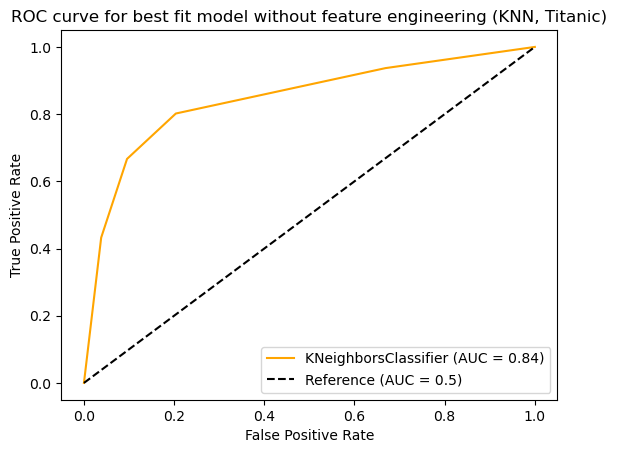

In [26]:
mutil.plot_roc(model, X_test, y_test, title="ROC curve for best fit model without feature engineering (KNN, Titanic)")

In [27]:
f1 = mutil.calc_f1(model, X_test, y_test)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.8016506751954513


C:\Users\Yon\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
